## Importing libraries

In [3]:
from matplotlib.pyplot import *
from numpy import *
from numpy.linalg import eig
from graphviz import Digraph
from IPython.display import Image
from sklearn.datasets import load_breast_cancer

## Main Code

In [67]:
g = Digraph("Network")
NodeCollection = []
Variables = []
counter = 0
dt = 0.01
class Node:
    name = None
    COLOR = "black"
    def __init__(self,name=None,draw=True):
        global counter,NodeCollection
        self.value = None
        self.outputNodes = []
        self.inputNodes = []
        self.id = counter
        self.draw = draw
        if self.name==None and name == None:
            self.name = "node "+str(self.id)
        elif name!=None:
            self.name = name
        if draw:
            g.node(str(self.id),self.name,color=self.COLOR)
        NodeCollection.append(self)
        counter += 1
    def __repr__(self):
        return f"name : {self.name}\n value : \n{self.value}\n grad : \n{self.grad}\n"
    def __add__(self,other):
        return Add([self,toNode(other)],"+")
    def __mul__(self,other):
        return Mul([self,toNode(other)],"*")
    def __pow__(self,other):
        return Pow([self,toNode(other)],"**")
    def __div__(self,other):
        return self*(other**(-1))
    def __neg__(self):
        return Neg([self],"-")
    def __sub__(self,other):
        return self + (-toNode(other))
    def recieve(self):
        self.grad = 0
        for n in self.outputNodes:
            DFDX = n.dfdx_value[self.id]
            GRAD = n.grad
            #print("recievong from",n.id,"aka",n.name)
            #print("DFDX",DFDX.shape)
            #print("GRAD",GRAD.shape)
            if len(DFDX.shape)==1 and GRAD.shape==(1,DFDX.shape[0]) and len(self.value.shape)==2:
                self.grad += GRAD.T @ DFDX[newaxis,:]
            elif DFDX.shape==(1,) or GRAD.shape ==(1,):
                self.grad += GRAD*DFDX
            else:
                #self.grad += dot(GRAD,DFDX)
                self.grad += GRAD @ DFDX
class Function(Node):
    COLOR = "green"
    f = None
    dfdx = None
    dfdx_value = None
    def __init__(self,inputNodes,name=None,draw=True):
        super().__init__(name,draw)
        for n in inputNodes:
            if self.draw and n.draw:
                g.edge(str(n.id),str(self.id))
            n.outputNodes.append(self)
        self.inputNodes = inputNodes
        self.forward()
    def __repr__(self):
        return f"name : {self.name}\n value : \n{self.value}\n grad : \n{self.grad}\n dfdx : \n{self.dfdx_value}\n"
    def forward(self):
        self.inputs = dict([(node.id,node.value) for node in self.inputNodes])
        self.value = self.f(self.inputs)
        self.dfdx_value = self.dfdx(self.inputs)
        n = int(prod(self.value.shape))
        #if n > 1:
        #    self.grad = identity(n)    
        #else :
        #    self.grad = array(1)
        self.grad = identity(n)
    def backward(self):
        for n in self.inputNodes:
            n.recieve()
            n.backward()
class Variable(Node):
    COLOR = "red"
    def __init__(self,value,name=None,draw=True):
        super().__init__(name,draw)
        self.value = value
        n = prod(self.value.shape)
        self.grad = identity(n)
        Variables.append(self)
    def backward(self):
        pass
    def forward(self):
        global dt
        self.grad.resize(self.value.shape)
        self.value = self.value - self.grad*dt
class Constant(Variable):
    COLOR="black"
    def recieve(self):
        pass
    def forward(self):
        pass
def toNode(other,draw=True):
    name = None
    if isinstance(other,Node):
        return other
    if type(other) != ndarray:
        if type(other) != iterable:
            name = str(other)
            other = array([other])
        else:
            other = array(other)
    return Constant(other,name,draw)
class Add(Function):
    name = "+"
    def f(self,inputs):
        S = 0
        for id in inputs:
            S = S + inputs[id]
        return S
    def dfdx(self,inputs):
        G = dict()
        for id in inputs:
            n = prod(inputs[id].shape)
            if n>1:
                G[id] = identity(n)
            else:
                G[id] = ones(prod(self.value.shape))[:,newaxis]
        return G
class Mul(Function):
    name = "*"
    def f(self,inputs):
        S = 1
        for id in inputs:
            S = S*inputs[id]
        return S
    def dfdx(self,inputs):
        G = dict()
        for id in inputs:
            S = 1
            for Id in inputs:
                if Id == id:
                    continue
                S = S*inputs[Id]
            S = S.flatten()
            n = prod(inputs[id].shape)
            if n > 1:
                m, = S.shape
                if m > 1:
                    S = diag(S)
                else :
                    S = S * identity(n)
            else:
                S = S[:,newaxis]
            G[id] = S
        return G
class Exp(Function):
    name = "exp"
    def f(self,inputs):
        return exp(next(iter(inputs.values())))
    def dfdx(self,inputs):
        id = next(iter(inputs.keys()))
        x = next(iter(inputs.values()))
        n = prod(x.shape)
        x = exp(x)
        x = x.flatten()
        if n>1:
            return {id:diagflat(x)}
        return {id:x[:,newaxis]}
class Pow(Function):
    name = "**"
    def f(self,inputs):
        x,n = inputs.values()
        return x**n
    def dfdx(self,inputs):
        ids = list(inputs.keys())
        x,n = inputs.values()
        m = prod(x.shape)
        if m > 1:
            return {ids[0]:diagflat(n*x**(n-1))}#,ids[1]:(log(x)*x**n).flatten()[:,newaxis]}
        return {ids[0]:(n*x**(n-1)).flatten()[:,newaxis]}#,ids[1]:(log(x)*x**n).flatten()[:,newaxis]}
class Neg(Function):
    name = "-"
    def f(self,inputs):
        return -next(iter(inputs.values()))
    def dfdx(self,inputs):
        id = next(iter(inputs.keys()))
        x = next(iter(inputs.values()))
        n = int(prod(x.shape))
        #if n>1:
        #    return {id:-identity(n)}
        #return {id:-array([1])}
        return {id:-identity(n)}
class Dot(Function):
    name = "."
    def f(self,inputs):
        x,y = inputs.values()
        d = dot(x,y)
        if len(d.shape)>0:
            return d
        return array([d])
    def dfdx(self,inputs):
        id1,id2 = inputs.keys()
        x,y = inputs.values()
        if len(x.shape) == 1:
            x = x[newaxis,:]
            y = y[newaxis,:]
        return {id1:y,id2:x}
class Sum(Function):
    name = "sum"
    def f(self,inputs):
        x, = inputs.values()
        return array([sum(x)])
    def dfdx(self,inputs):
        x, = inputs.values()
        id, = inputs.keys()
        n = prod(x.shape)
        return {id:ones((1,n))}
class Sin(Function):
    name = "sin"
    def f(self,inputs):
        x, = inputs.values()
        return sin(x)
    def dfdx(self,inputs):
        x, = inputs.values()
        id, = inputs.keys()
        n = prod(x.shape)
        return {id:diagflat(cos(x))}
class Cos(Function):
    name = "cos"
    def f(self,inputs):
        x, = inputs.values()
        return cos(x)
    def dfdx(self,inputs):
        x, = inputs.values()
        id, = inputs.keys()
        n = prod(x.shape)
        return {id:diagflat(sin(x))}
class MatFunc(Function):
    def forward(self):
        self.inputs = dict([(node.id,node.value) for node in self.inputNodes])
        self.value = self.f(self.inputs)
        n = int(prod(self.value.shape))
        self.grad = identity(n)
    def __init__(self, inputNodes, name=None, draw=True):
        super().__init__(inputNodes, name, draw)
        for n in self.inputNodes:
            if isinstance(n,MatFunc):
                n.recieve = n.send
            else:
                n.recieve = lambda:None
    def recieve(self):
        super().recieve()
        self.send()
class MatMul(MatFunc):
    name = "@"
    def f(self,inputs):
        W,X = inputs.values()
        return W @ X
    def send(self):
        w,x = self.inputNodes
        W = w.value
        X = x.value
        G = self.grad
        w.grad = G @ X.T
        x.grad = W.T @ G
class SigmM(MatFunc):
    name = "Sigma"
    def f(self,inputs):
        X, = inputs.values()
        return sigmoid(X)
    def send(self):
        x, = self.inputNodes
        X = x.value
        G = self.grad
        sig = sigmoid(X)
        x.grad = G*(sig**2/exp(X))
class SqNorM(MatFunc):
    name = "Norm"
    def f(self,inputs):
        X, = inputs.values()
        return array([linalg.norm(X,'fro')])**2
    def send(self):
        x = self.inputNodes[0]
        x.grad = 2*x.value*self.grad
class DotM(MatFunc):
    name = "."
    def f(self,inputs):
        X,Y = inputs.values()
        return sum(X*Y)
    def send(self):
        x,y = self.inputNodes
        X,Y = x.value,y.value
        G = self.grad # assumed to be a scalar
        x.grad = Y*G
        y.grad = X*G
class AddM(MatFunc):
    name = "+"
    def f(self,inputs):
        S = 0
        for X in inputs.values():
            S = S + X
        return S
    def send(self):
        for n in self.inputNodes:
            if len(n.value.shape) == 1 or n.value.shape[0] == 1:
                n.grad = sum(self.grad,axis=0)
            else :
                n.grad = self.grad
class NegM(MatFunc):
    name = "-"
    def f(self,inputs):
        X, = inputs.values()
        return -X
    def send(self):
        x = self.inputNodes[0]
        x.grad = -self.grad


def Sigm(inputNode,name="S",draw=True):
    out = Neg([inputNode],None,False)
    out = Exp([out],None,False)
    out = Add([out,Constant(array([1]),None,False)],None,False)
    out = Pow([out,Constant(array([-1]),None,False)],name,True)
    if draw and inputNode.draw:
        g.edge(str(inputNode.id),str(out.id))
    return out
def Layer(X,pin,pout,name=None,bias=False):
    W = random.random((pin,pout))
    W = Variable(W,"W")
    Y = MatMul([X,W])
    if bias:
        b = random.random(pout)
        b = Variable(b,"b")
        Y = AddM([Y,b]) 
    Y = SigmM([Y],name)
    return Y
def SqErM(inputNodes):
    yp,y = inputNodes
    myp = NegM([yp])
    er = AddM([myp,y])
    s = SqNorM([er],"L")+0
    return s
def perceptron(layer,draw=True):
    nl = []
    for n in layer :
        nl.append(Mul([n,Variable(random.random(1),None,False)],None,False))
    S = Add(nl,"+",False)
    S = Sigm(S,"P",draw)
    for n in layer:
        if draw and n.draw:
            g.edge(str(n.id),str(S.id))
    S.nl = nl
    return S
def SqEr(inputNodes,name="L",draw=True):
    x,y = inputNodes
    out = Neg([y],None,False)
    out = Add([x,out],None,False)
    two = Constant(array([2]),None,False)
    out = Pow([out,two],None,False)
    out = Sum([out],name,draw)
    for n in inputNodes:
        if draw and n.draw:
            g.edge(str(n.id),str(out.id))
    return out
def BacProp(show=False):
    global NodeCollection
    for i in range(len(NodeCollection)-2,-1,-1):
        n=NodeCollection[i]
        n.recieve()
        if show:
            print(n)
def forProp(show=False):
    global NodeCollection
    for i in range(len(NodeCollection)):
        n=NodeCollection[i]
        n.forward()
        if show:
            print(n)
def BackTrackAndDescend(iterations=100,alpha=2,dt_init=10**-2):
    global dt,NodeCollection,Variables
    L = NodeCollection[-1]
    print("before",L.value)
    i = 0
    for _ in range(iterations):
        dt = dt_init
        BacProp()
        oldL = L.value
        forProp()
        i += 1
        S = sum([(linalg.norm(n.grad))**2 for n in Variables])
        while (oldL-L.value)[0] >= 0.5*(dt)*S:
            dt *= alpha
            oldL = L.value
            forProp()
            i+= 1
        if oldL < L.value:
            dt = -dt
            forProp()
            dt = -dt
            i += -1
        if dt==dt_init:
            dt_init /= alpha
    print("after",L.value)
    print("i =",i)
def Descend(iterations=100):
    global dt,NodeCollection,Variables
    L = NodeCollection[-1]
    print("before",L.value)
    for i in range(iterations):
        BacProp()
        forProp()
    print("after",L.value)
def Reset():
    global g,NodeCollection,Variables,counter,dt
    g = Digraph("Network")
    NodeCollection = []
    Variables = []
    counter = 0
    dt = 0.01
def Show(g,w=100):
    display(Image(g.pipe("png"),width=w))
def sigmoid(x):
    return 1/(1+exp(-x))

class PerceptronNet:
    def __init__(self,LS=[3,3,3]):
        Reset()
        n = LS.pop(0)
        layer0 = [Constant(ones(1)) for _ in range(n)]
        layers = [layer0]
        for n in LS:
            last_layer = layers[-1]
            layers.append([perceptron(last_layer) for _ in range(n)])
        P = perceptron(layers[-1])
        y = Constant(ones(1),"y")
        L = SqEr([P,y])
        self.y = y
        self.layer0 = layer0
        self.P = P
        self.L = L
        self.layers = layers
    def assign(self,X,y):
        if X.shape[1]!= len(self.layer0):
            print("Can't deal with this many variables.")
            return
        self.y.value = y
        for c in range(X.shape[1]):
            self.layer0[c].value = X[:,c]
        forProp()
    def predict(self):
        forProp()
        loss = self.L.value
        y_pred = self.P.value
        return y_pred,loss
class LayerNet:
    def __init__(self,X,y,middle=[3,3,3],bias=False,normalise=False):
        if isinstance(bias,bool):
            bias = [bias for _ in range(len(middle))]
        Reset()
        m = X.shape[1]
        n = y.shape[1]
        mu = mean(X,axis=0)
        sdi = diag(var(X,axis=0)**(-0.5))
        X = Constant(X,"X")
        y = Constant(y,"y")
        self.y = y
        self.X = X
        if normalise:
            nmu = Constant(-mu,'b')
            sdi = Constant(sdi,"W")
            X = AddM([X,nmu],"shifted X")
            X = MatMul([X,sdi],"normalised X")
        out = Layer(X,m,middle[0],"layer1",True)
        for i in range(len(middle)-1):
            out = Layer(out,middle[i],middle[i+1],f"layer {i+1}",bias[i])
        y_pred = Layer(out,middle[-1],n,'y_pred',bias[-1])
        L = SqErM([y_pred,y])
        self.y_pred = y_pred
        self.L = L
    def predict(self,X,y,testName = ""):
        self.X.value = X
        self.y.value = y
        forProp()
        y_pred = self.y_pred.value
        print("accuracy on test ",testName," : ",round(mean(around(y_pred)==y)*100,2),"%")
        return y_pred
    def train(self,iterations=100,dtvalue=0.01):
        global dt
        dtold = dt
        dt = dtvalue
        y_pred = self.y_pred.value
        y = self.y.value
        print("accuracy before training : ",round(mean(around(y_pred)==y)*100,2),"%")
        Descend(iterations)
        dt = dtold
        y_pred = self.y_pred.value
        y = self.y.value
        print("accuracy on training : ",round(mean(around(y_pred)==y)*100,2),"%")


## Training a neural net on self made data

accuracy before training :  73.0 %
before [23.59915675]
after [4.58535922]
accuracy on training :  94.0 %


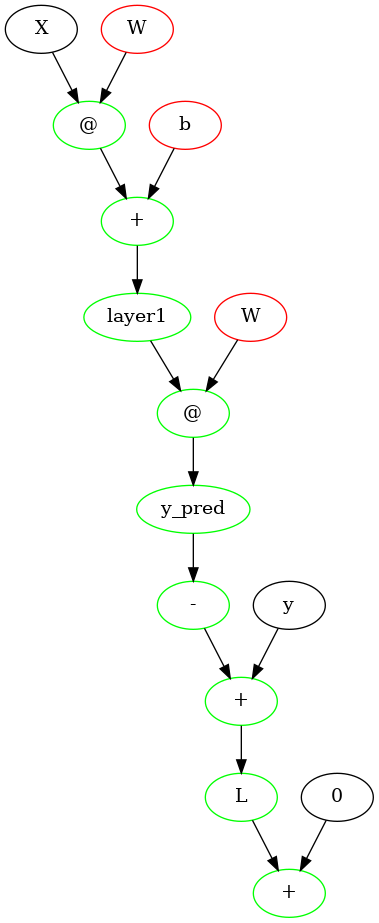

In [73]:
Reset()
N = 100
m = 10
n = 1
X = random.random((N,m))
M = 1-2*random.random((m,n))
y = (sign((X**2-X) @ M)+1)/2
net = LayerNet(X,y,[5])
net.train(1000,0.1)
Show(g)

## Training the neural net on breast cancer dataset

accuracy before training :  51.33 %
before [155.43117133]
after [11.59418918]
accuracy on training :  98.0 %
accuracy on test    :  98.14 %


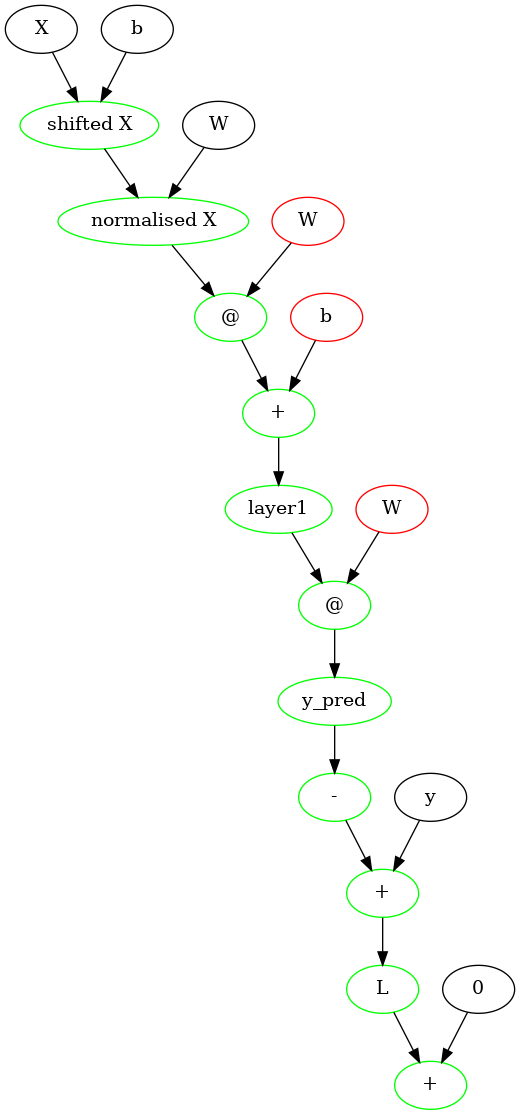

In [72]:
X,y = load_breast_cancer(return_X_y=True)
m = X.shape[1]
X = X[:]
y = y[:,newaxis]
X,Xtest = X[:300,:],X[300:,:]
y,ytest = y[:300,:],y[300:,:]

net = LayerNet(X,y,[5],normalise=True)
net.train(100,0.01)
net.predict(Xtest,ytest)
Show(g)

### The same dataset and neural net, but implemented using perceptrons directly, rather than matrices.

62.741652021089635
before [167.11131104]
after [31.58534127]
94.5518453427065


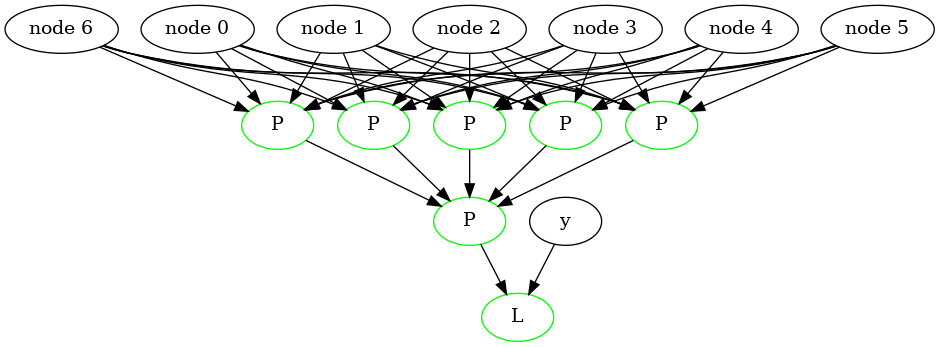

In [74]:
X,y = load_breast_cancer(return_X_y=True)

# PCA
mu = mean(X,0)
sd = var(X,0)**0.5
X = (X-mu)/sd
## Assume X = Y @ R.T and Y.T @ Y = D
C = X.T @ X
D,RT = eig(C)
idx = argsort(D)[-7:]
D = D[idx]
RT = RT[:,idx]
X = X @ RT
X = real(X)

#Neural Net
net = PerceptronNet([7,5])
net.assign(X,y)
dt = 0.001
print(mean(around(net.P.value)==net.y.value)*100)
Descend(100)
print(mean(around(net.P.value)==net.y.value)*100)
Show(g,200)

## Random minimisation problems

### Rotating a unit vector to match another unit vector using automatic differentiation

before [0.92691592]
after [-1.]


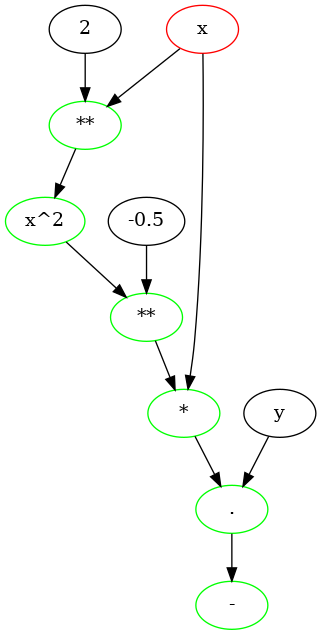

In [68]:
Reset()
x = Variable(-ones(2)/sqrt(2)+0.5*random.random(2),"x")
y = Constant(ones(2)/sqrt(2),"y")
xhat = x*Sum([x**2],"x^2")**-0.5
a = -Dot([xhat,y])
dt = 0.1
Descend()
Show(g,150)

### yet another minimisation problem

before [0.00999983]
after [0.00018243]


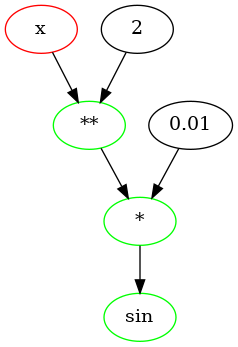

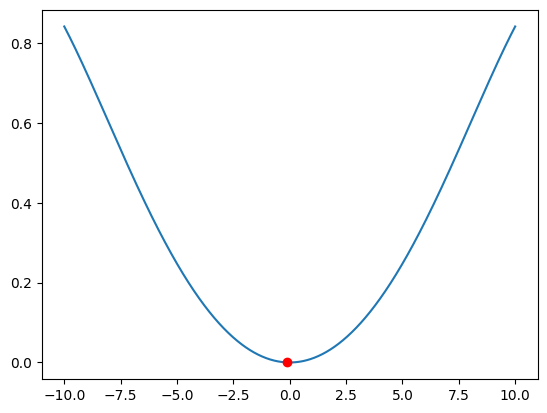

In [111]:
Reset()
x = Variable(array([-1.]),"x")
y = Sin([(x**2)*0.01])
dt = 0.1
Descend(1000)
xm,ym = x.value,y.value
x = linspace(-10,10,1000)
y = sin((x**2)/100)
plot(x,y)
plot([xm],[ym],'ro')
Show(g)